### CS5228 Mini Project Team 07 - Supervised Learning

#### Objective

This notebook aims to train models to predict whether a customer will churn based on the processed features. 

The following models are trained and compared:
- Logistic regression
- Random Forest
- XGBoost

#### Imports

In [25]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import xgboost as xgb

In [26]:
with open('./dataset/cleaned_datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)
    
min_max_train_df = datasets['min_max_scale_pca']['train']
min_max_test_df = datasets['min_max_scale_pca']['test']
standard_train_df = datasets['standard_scale_pca']['train']
standard_test_df = datasets['standard_scale_pca']['test']

Use recall to be the scoring function since we want to minimize false negatives - We want to identify the churning customers more accurately, potentially at the cost of misclassifying some customers who do not churn as churning. After identifying the churning individuals more targeted marketing / pricing strategies can be applied to retain them.

In [27]:
def train_model_with_grid_search(model, param_grid, X_train, y_train, kfold=5):
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='recall')
    grid_search.fit(X_train, y_train)
    return grid_search

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('ROC AUC:', roc_auc_score(y_test, y_pred))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=model_name)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')  # <- Add reference line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

Split features and target variable Churn

In [28]:
USE_MIN_MAX = False

In [29]:
if USE_MIN_MAX:
    X_train = min_max_train_df.drop('Churn', axis=1)
    y_train = min_max_train_df['Churn']
    X_test = min_max_test_df.drop('Churn', axis=1)
    y_test = min_max_test_df['Churn']
else:
    X_train = standard_train_df.drop('Churn', axis=1)
    y_train = standard_train_df['Churn']
    X_test = standard_test_df.drop('Churn', axis=1)
    y_test = standard_test_df['Churn']

Upsampling minority class to avoid overfitting on majority class

In [30]:
def upsample_minority_class(X_train, y_train):
    X = pd.concat([X_train, y_train], axis=1)
    not_churn = X[X['Churn'] == 0]
    churn = X[X['Churn'] == 1]
    
    # Resampling with replacements to inflate the minority churning customers
    churn_upsampled = resample(churn, replace=True, n_samples=len(not_churn), random_state=42)
    upsampled = pd.concat([not_churn, churn_upsampled])
    return upsampled.drop('Churn', axis=1), upsampled['Churn']

X_train_upsampled, y_train_upsampled = upsample_minority_class(X_train, y_train)

In [31]:
X_train_upsampled

,State_freq,State_churn_prob,Account length,International plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes
0,0.019505,0.192308,0.692163,0,1.247508,1.579670,0.484868,-0.058619,-0.050781,0.857403,-0.469031,-0.085020
1,0.024756,0.151515,0.161278,0,1.320985,-0.329918,1.135375,-0.095916,0.147654,1.048458,0.149054,1.242179
2,0.018755,0.280000,0.919686,0,-0.589414,1.179302,0.685024,-1.554439,0.494917,-0.759668,0.200561,0.704125
3,0.024756,0.151515,-0.420168,1,-0.589414,2.212509,-1.466653,-2.718509,-0.596479,-0.084083,-0.572045,-1.304609
4,0.019505,0.134615,-0.647691,1,-0.589414,-0.235822,0.634985,-1.022461,1.090224,-0.281046,1.076181,-0.049150
...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.018005,0.229167,0.489921,0,-0.589414,0.601813,1.535687,0.176943,0.197263,-0.669065,-0.211496,-1.770922
1062,0.018005,0.208333,-1.153296,0,-0.589414,1.959742,1.185414,0.598992,0.296481,0.581654,2.054815,1.636752
2165,0.026257,0.185714,0.616323,1,1.541416,1.500334,-0.966263,-0.720156,0.594135,1.389205,0.870152,2.425897
2114,0.016129,0.209302,1.020807,0,1.761847,2.636862,-0.415834,1.625651,0.346090,0.164092,0.561110,-1.268739


In [32]:
X_test

,State_freq,State_churn_prob,Account length,International plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes
0,0.013128,0.085714,0.414080,0,-0.589414,0.092590,-0.165639,2.968355,-0.993351,0.288179,-0.520538,-0.551334
1,0.020255,0.111111,-0.900493,0,-0.589414,-0.929547,1.835921,0.551880,-0.844524,0.150304,0.561110,0.883476
2,0.025506,0.176471,1.526412,0,-0.589414,2.830588,-1.666809,2.304855,-0.149999,-0.799061,1.436730,-1.735052
3,0.018380,0.224490,0.262399,0,-0.589414,-1.274564,0.134595,-1.238393,0.098046,-0.227866,0.252068,-0.910036
4,0.016504,0.045455,-1.304977,0,-0.589414,-1.110358,0.835141,0.288835,0.445308,-0.442556,-0.520538,0.309552
...,...,...,...,...,...,...,...,...,...,...,...,...
662,0.022881,0.065574,0.338240,0,1.320985,-0.781946,-0.615990,-0.877198,1.239051,0.914523,-0.314510,0.453033
663,0.024756,0.106061,0.135998,0,1.541416,-1.769028,1.535687,0.068977,1.536704,0.558019,-1.396158,-0.766555
664,0.021380,0.105263,-1.026894,0,-0.589414,0.266021,0.885180,-2.265051,0.494917,0.175909,1.745772,1.062828
665,0.033008,0.079545,1.475851,0,-0.589414,-0.178627,0.685024,-0.052730,0.246872,-0.147111,-0.932595,0.488904


#### Logistic regression model

Confusion Matrix:
[[448 124]
 [ 37  58]]
Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.78      0.85       572
        True       0.32      0.61      0.42        95

    accuracy                           0.76       667
   macro avg       0.62      0.70      0.63       667
weighted avg       0.84      0.76      0.79       667

Accuracy: 0.7586206896551724
ROC AUC: 0.6968715495031286


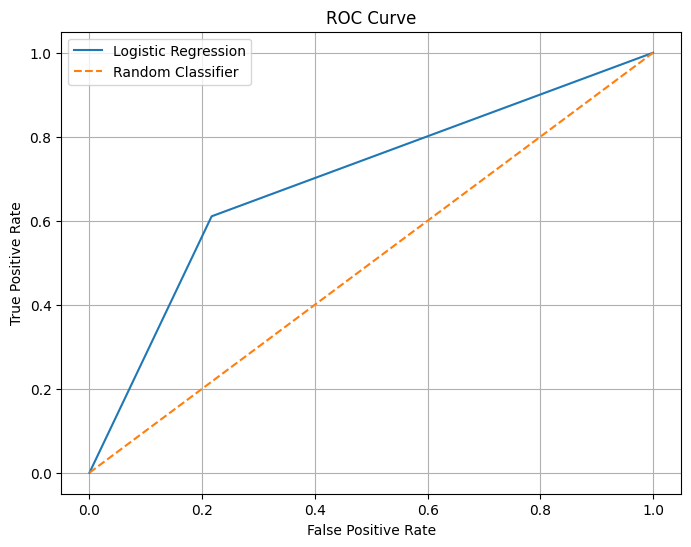

In [33]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(random_state=42)
lr_grid_search = train_model_with_grid_search(lr, param_grid, X_train_upsampled, y_train_upsampled)
evaluate_model(lr_grid_search, X_test, y_test, model_name='Logistic Regression')

Feature importance for logistic regression

state_churn_prob derived upon training set appears to be a significant feature for the logistic regression model, which means we can choose to make targeted advertisement to customers in a particular state which has high churning probablity to retain more customers.

In [34]:
# Get coefficients
coefficients = lr_grid_search.best_estimator_.coef_[0]

# Create a dataframe
coef_df = pd.DataFrame({
    'Feature': X_train_upsampled.columns,
    'Coefficient': coefficients,
    'Absolute Coefficient': abs(coefficients)
}).sort_values(by='Absolute Coefficient', ascending=False)

print(coef_df)

                  Feature  Coefficient  Absolute Coefficient
1        State_churn_prob     7.455189              7.455189
3      International plan     1.892932              1.892932
0              State_freq    -0.667696              0.667696
5       Total day minutes     0.462463              0.462463
4   Number vmail messages    -0.299398              0.299398
7       Total eve minutes     0.148599              0.148599
11     Total intl minutes     0.093853              0.093853
9     Total night minutes     0.083803              0.083803
10      Total night calls    -0.054140              0.054140
6         Total day calls     0.038826              0.038826
2          Account length     0.029755              0.029755
8         Total eve calls     0.008500              0.008500


#### Random forest model

Confusion Matrix:
[[483  89]
 [ 41  54]]
Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.84      0.88       572
        True       0.38      0.57      0.45        95

    accuracy                           0.81       667
   macro avg       0.65      0.71      0.67       667
weighted avg       0.84      0.81      0.82       667

Accuracy: 0.8050974512743628
ROC AUC: 0.7064133235185867


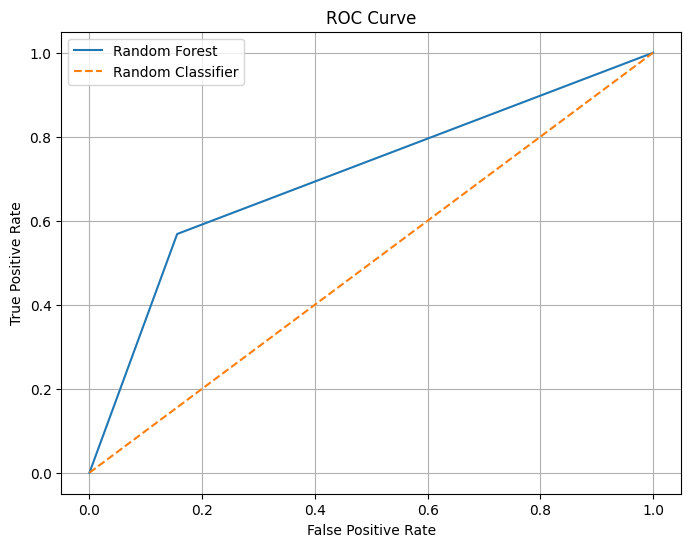

In [35]:
param_grid = {'n_estimators': [10, 50], 'max_depth': [3, 5],   'max_features': [2, 4], 'criterion': ['gini', 'entropy']}
rf = RandomForestClassifier(random_state=42)
rf_grid_search = train_model_with_grid_search(rf, param_grid, X_train_upsampled, y_train_upsampled)
evaluate_model(rf_grid_search, X_test, y_test, model_name='Random Forest')

Feature importance for random forest

Total day miutes and International plan are two other significant features for the random forest model, which indicates that the level of engagement to the service (as recflected by having an international plan and high total day minutes) determines the probablity of churning to a large extent. Therefore, a possible strategy is to increase the user scenario of telephone communications so as to encourage customers to retain their usage plans.

In [36]:
importances = rf_grid_search.best_estimator_.feature_importances_

# Create a dataframe to view nicely
importance_df = pd.DataFrame({
    'Feature': X_train_upsampled.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                  Feature  Importance
5       Total day minutes    0.231996
3      International plan    0.166776
1        State_churn_prob    0.159305
11     Total intl minutes    0.112049
4   Number vmail messages    0.078829
9     Total night minutes    0.076527
7       Total eve minutes    0.053505
6         Total day calls    0.037419
8         Total eve calls    0.029890
2          Account length    0.026313
0              State_freq    0.019929
10      Total night calls    0.007462


The logistic regression model might be the best model given its highest recall, which is the optimization objective as we argued in the upsampling section.

#### XGBoost Model

Confusion Matrix:
[[556  16]
 [ 41  54]]
Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.97      0.95       572
        True       0.77      0.57      0.65        95

    accuracy                           0.91       667
   macro avg       0.85      0.77      0.80       667
weighted avg       0.91      0.91      0.91       667

Accuracy: 0.9145427286356822
ROC AUC: 0.7702245123297754


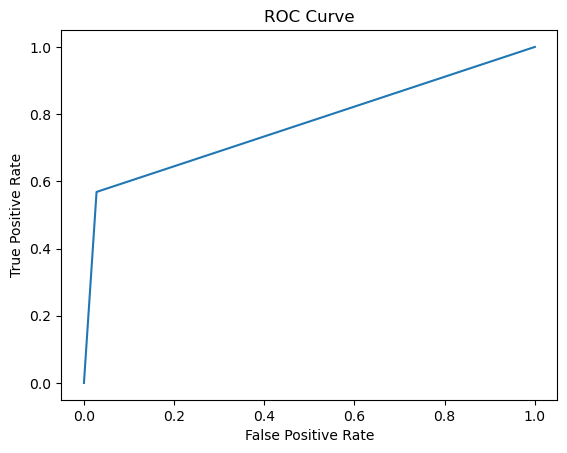

In [7]:
# Create an XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Define a parameter grid for XGBoost. You can adjust these parameters as needed.
param_grid_xgb = {
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0]
}

# Perform grid search with the XGBoost classifier
xgb_grid_search = train_model_with_grid_search(xgb_clf, param_grid_xgb, X_train_upsampled, y_train_upsampled)

# Evaluate the best model found via grid search on the test data
evaluate_model(xgb_grid_search, X_test, y_test, model_name='XGBoost')

In [10]:
print(xgb_grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


In [11]:
print(xgb_grid_search.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

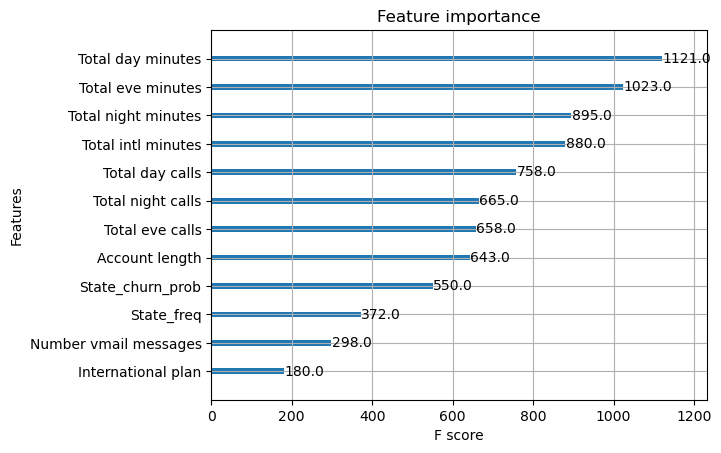

In [12]:
xgb.plot_importance(xgb_grid_search.best_estimator_, max_num_features = 20)

In [13]:
xgb_grid_search.best_estimator_.save_model('dataset/xgb.model')

d:\DevelopKits\Anaconda3\envs\cs4248\lib\site-packages\xgboost\core.py:158: UserWarning: [00:05:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
